# Topic analysis based on Genius songs lyrics

Author : lievre.thomas@gmail.com

---

In this notebook, we will explore the genius data extract from [Kaggle](https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information).

**The aim of this analysis is to retrieve topic from lyrics and retrieve main topics by year or decade.**

This notebook was carried out in the context of a class project imposed by the [text mining course (TDDE16)](https://www.ida.liu.se/~TDDE16/project.en.shtml) of Linköpings universitet.


## Few informations about Genius website

Genius is an American digital company founded on August 27, 2009, by Tom Lehman, lan Zechory, and Mahbod Moghadam. Originally launched as Rap Genius with a focus on hip-hop music, it was initially a crowdsourced website where people could fill in the lyrics of rap music and give an interpretation of the lyrics. Over the years the site has grown to contain several million annotated texts from all eras ( from [Wikipedia Genius page](https://en.wikipedia.org/wiki/Genius_(company))).


## Load the data in memory

Data are all contain in a big 9GB csv file (around 5 millions rows). It could be dificult to load all this data in our computer memory. To deal with this issue, I made a loading class to split the data in 6 pickles files to improve the compressness of the data which aim to improve the loading speed in the memory. Then the pickles are randomly draw to improve generality of the data. We currently assumed the data pickles batch are identically distributed (we will explore the data batches at the second part). The class below deal with all the process.

In [1]:
import pandas as pd
from random import seed, sample
import pickle
import glob
import os

class Loader():

    def __init__(self, in_path, out_path):
        """
        Args:
            in_path (str): csv input path.
            out_path (str): Output directory path to store the pickles.
            chunksize (int, optional): Chunksize for DataFrame reader. Defaults to 10**6. 
        """

        self.__in_path = in_path
        self.__out_path = out_path
        self.__chunksize = 10**6

    def __produce_pickles(self):
        """produce pickles by reading csv by chunksize
        """
        with pd.read_csv(self.__in_path, chunksize = self.__chunksize) as reader:
            try:
                os.makedirs(self.__out_path)
            except FileExistsError:
                # directory already exists
                pass
            for i, chunk in enumerate(reader):
                out_file = self.__out_path + "/data_{}.pkl".format(i+1)
                with open(out_file, "wb") as f:
                    pickle.dump(chunk, f, pickle.HIGHEST_PROTOCOL)
    
    def load_pickle(self, pickle_id):
        """load a pickle file by id

        Args:
            pickle_id (int): pickle id.

        Raises:
            Exception: The path of the given id isn't a file

        Returns:
            obj: DataFrame
        """
        # produce the pickles if the directory not exists or
        # if the directory is empty 
        if (not os.path.exists(self.__out_path)) or \
              (len(os.listdir(self.__out_path)) == 0):
            self.__produce_pickles()
        
        # get the file path following the pickle_id
        # given in parameter
        file_path = self.__out_path + \
            "/data_" + str(pickle_id) + ".pkl"

        if os.path.isfile(file_path):
            df = pd.read_pickle(file_path)
        else:
            raise Exception("The pickle file data_{}.pkl doesn't exist".format(pickle_id))
        return df
        

    def random_pickles(self, n_pickles = 3, init = 42, verbose = True):
        """random reader over pickles files

        Args:
            n_pickles (int, optional): number of pickles to load. Defaults to 3.
            init (int, optional): Integer given to the random seed. Defaults to 42.
            verbose (bool, optional): Print the loaded files. Defaults to True

        Raises:
            Exception: Stop the process if n_pickles exceed pickle files number.

        Returns:
            obj: pd.Dataframe
        """

        # produce the pickles if the directory not exists or
        # if the directory is empty 
        if (not os.path.exists(self.__out_path)) or \
              (len(os.listdir(self.__out_path)) == 0):
            self.__produce_pickles()

        pickle_files = [name for name in
                        glob.glob(self.__out_path + "/data_*.pkl")]
        # draw p_files        
        seed(init)

        if n_pickles <= 6:
            random_p_files = sample(pickle_files, n_pickles)
        else:
            raise Exception("The parameter n_pickles (" +
                            "{}) exceed the numbers of pickle files ({})"\
                                .format(n_pickles, len(pickle_files)))
        # print the drawed files
        if verbose:
            print("Loaded pickles:")
            for p in random_p_files:
                print(p)

        # load random pickles file
        df_list = [pd.read_pickle(p) for p in random_p_files]

        # create the dataframe by concatenate the previous
        # dataframes list
        df = pd.concat(df_list, ignore_index = True)
        return df

In [2]:
# create reader
#  /!\ change path in kaggle
loader = Loader(in_path = "./song_lyrics.csv", out_path = "data/")

df = loader.random_pickles(n_pickles = 1)

Loaded pickles:
data/data_5.pkl


Batchs of data are randomly loaded in the memory. The number of batchs loaded depends on the memory capacity of the computer running the script. For the analysis, we will only works on the random samples loaded (All the data in Kaggle).  

## Exploring the coarse data

Let's visualize and explore the coarse data before a part of deeper analysis.

In [3]:
df.head()

title   tag  \
0  Doja Cat - So High Traducción al Español   pop   
1                       Love Me or Leave Me   rap   
2                                  Wake Up    rap   
3             ​harm none its me I cant find  rock   
4                       Niklas - Hjertesorg   rap   

                          artist  year  views  \
0  Genius Traducciones al Espaol  2014    307   
1                   3D_unleashed  2020    116   
2                  NaNa / NaNa$i  2020    336   
3                    Mary Mortem  2020     65   
4                        DJTUBIS  2019      7   

                             features  \
0  {"Genius Traducciones al Español"}   
1                                  {}   
2                 {"NaNa / NaNa\\$i"}   
3                                  {}   
4                                  {}   

                                              lyrics       id language_cld3  \
0  [Coro]\nSoplar, hierba, coca, pop x\nAcelerand...  6049063            es   
1  [verse 1]\n(yeah)i know I'm worthless(but that...  6049064            en   
2  I woke up when the sun's down\nPut on my gold ...  6049065            en   
3  [Verse 1]\nCreep like I’m nothing but bones\nA...  6049066            en   
4  Niklas knuste hjertet mitt (ja)\nJeg forteller...  6049069            no   

  language_ft language  
0          es       es  
1          en       en  
2          en       en  
3          en       en  
4          da      NaN

For each songs, we've got several informations :
- title of the song
- the tag (which kind of music)
- the artist singer name
- the release year
- the number of page views
- the featuring artists names
- the lyrics
- the genius identifier
- Lyrics language according to [CLD3](https://github.com/google/cld3). Not reliable results are NaN. CLD3 is a neural network model for language indentification.
- Lyrics language according to [FastText's langid](https://fasttext.cc/docs/en/language-identification.html). Values with low confidence (<0.5) are NaN. FastText's langid is library developped by Facebook’s AI Research lab for efficient learning of word representations and sentence classification. fastText has also published a fast and accurate tool for text-based language identification capable of recognizing more than 170 languages.
- Combines language_cld3 and language_ft. Only has a non NaN entry if they both "agree".

More information at this link : https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information

In [4]:
df.dtypes

title            object
tag              object
artist           object
year              int64
views             int64
features         object
lyrics           object
id                int64
language_cld3    object
language_ft      object
language         object
dtype: object

In [5]:
# display the size
print('Data frame size (row x columns):', df.size)
print('Data rows number: ', len(df))
print('Number of unique songs (following genius id): ', len(df.id.unique()))

Data frame size (row x columns): 11000000
Data rows number:  1000000
Number of unique songs (following genius id):  1000000


Genius id seems to be the unique rows identifier.

Let's vizualise size of the coarse data over years before preprocessing to compare batch distributions. One things to know before vizualise the data, the pickles are create by chunks reading. 

In [6]:
df_data_1 = loader.load_pickle(1)
df_data_1.head(5)

title  tag     artist  year   views  \
0          Killa Cam  rap    Cam'ron  2004  173166   
1         Can I Live  rap      JAY-Z  1996  468624   
2  Forgive Me Father  rap   Fabolous  2003    4743   
3       Down and Out  rap    Cam'ron  2004  144404   
4             Fly In  rap  Lil Wayne  2005   78271   

                                       features  \
0                   {"Cam\\'ron","Opera Steve"}   
1                                            {}   
2                                            {}   
3  {"Cam\\'ron","Kanye West","Syleena Johnson"}   
4                                            {}   

                                              lyrics  id language_cld3  \
0  [Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...   1            en   
1  [Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...   3            en   
2  Maybe cause I'm eatin\nAnd these bastards fien...   4            en   
3  [Produced by Kanye West and Brian Miller]\n\n[...   5            en   
4  [Intro]\nSo they ask me\n"Young boy\nWhat you ...   6            en   

  language_ft language  
0          en       en  
1          en       en  
2          en       en  
3          en       en  
4          en       en

In [7]:
df_data_1.tail(5)


title   tag              artist  year  views  \
999995                        Crash   pop         (AAA) (JPN)  2008    130   
999996             Dont Come For Me   pop            Ari Gold  2001    614   
999997              Malum Infinitum   pop        Gernotshagen  2002     16   
999998  Benton Harbor Blues reprise   pop  The Fiery Furnaces  2006     94   
999999                     Solitude  rock      Jerry Cantrell  2002   2070   

                       features  \
999995  {"トリプル・エー (AAA) (JPN)"}   
999996                       {}   
999997                       {}   
999998                       {}   
999999                       {}   

                                                   lyrics       id  \
999995  [トリプルエー（AAA）「Crash」歌詞]\n\n太陽が眩しいせいか\n頑丈なRuleのせ...  1325195   
999996  Let me just ask you\nHow you could do it\nHow ...  1325203   
999997  Eine Geschichte aus uralten Zeiten\nVon einer ...  1325196   
999998  As I try to fill all of my empty days\nI stumb...  1325197   
999999  There's no out, downside up for good\nNo light...  1325198   

       language_cld3 language_ft language  
999995            ja          ja       ja  
999996            en          en       en  
999997            de          de       de  
999998            en          en       en  
999999            en          en       en

In [8]:
df_data_2 = loader.load_pickle(2)
df_data_2.head(5)

title   tag                 artist  year  views  \
1000000            Life Floats By  rock           The Jayhawks  2000     91   
1000001           Red Rubber Ball  rock  Streetlight Manifesto  2010    725   
1000002  The Lads Who Fought  Won   pop     The Real McKenzies  2008   1386   
1000003              Burning Love   pop        Mother's Finest  1977    571   
1000004           Patent na luxus   rap               O.S.T.R.  2003    861   

                      features  \
1000000                     {}   
1000001                     {}   
1000002                     {}   
1000003  {"Mother\\'s Finest"}   
1000004                     {}   

                                                    lyrics       id  \
1000000  [Verse 1]\nAbuse me and confuse me\nBut never,...  1325199   
1000001  I should have known you'd bid me farewell\nThe...  1325200   
1000002  That Serbian man\nAssassinated Archduke Ferdin...  1325201   
1000003  Lord Almighty\nI feel my temperature rising\nH...  1325202   
1000004  [Zwrotka 1]\nWino z gatunku wytrawnych - Dom P...  1325204   

        language_cld3 language_ft language  
1000000            en          en       en  
1000001            en          en       en  
1000002            en          en       en  
1000003            en          en       en  
1000004            pl          pl       pl

In [9]:
# free
del df_data_1, df_data_2

The last diplayed table gives us some information about the data. The csv file seems to be sort by id, so the pickle files are then sort too.

In [10]:
import plotly.express as px
import plotly.io as pio

# change theme template for every graph below
pio.templates.default = "plotly_white"


# get some information about the pickle data
def pickle_informations(data = loader):
    rows = []
    for i in range(1, len(os.listdir('data')) + 1):
        df = data.load_pickle(i)
        rows.append(len(df))
        del df
    return rows

# get the rows
rows = pickle_informations()

# create the dataframe
df_data = pd.DataFrame(
    {'batch' : ['data ' + str(i) for i in range(1,len(rows) + 1)],
    'rows' : rows})

fig = px.bar(df_data, x="batch", y="rows")
fig.show()

Batch seems to have the same number of rows rexcept for the last one which is consistent because batch are create iteratively by 10e6 chunks over the csv The last batch could be seen as a rest.

In [11]:
import plotly.graph_objects as go

def add_bar(i, y1, y2, color, data = loader):
    df = data.load_pickle(i)
    df = df[(df.year >= y1) & (df.year <= y2)]
    df_year = df.groupby(['year']).size().reset_index(name='count')
    new_bar = go.Bar(
                x = df_year.year.values,
                y = df_year['count'].values,
                name = 'data_'+ str(i),
                marker = {'color' : color})
    new_trend = go.Scatter(
                x = df_year.year.values,
                y = df_year['count'].values,
                mode="lines",
                line={'color' : color,
                    'width' : 0.5},
                showlegend=False)
    del df_year, df
    return new_bar, new_trend


def multi_barplot(year1, year2, colors):    
    # create a empty plotly.Figure object
    fig = go.Figure() 
    # compute the batch number
    n_batch = len(os.listdir('data'))
    # test the color list feed in argument
    # fit well with the batch number
    if n_batch > len(colors):
        raise Exception(
            "The colors list size({})doesn't ".format(len(colors)) +
            "fit with the number of data".format(n_batch))
    for i in range(1, n_batch + 1):
        fig.add_traces((add_bar(i, year1, year2, colors[i-1])))
    fig.update_layout(
        title = "Data distribution over years ({} - {})"
            .format(year1, year2),
        xaxis_title="years",
        yaxis_title="title",
        legend_title="Data batch")
    return fig


In [12]:
import plotly.colors as col

# create the color list
colors = col.qualitative.Plotly

# 1990 - 2023
fig1 = multi_barplot(1960, 1989, colors)
fig1.show()
# 1960 - 1990
fig2 = multi_barplot(1990, 2023, colors)
fig2.show()

The first bar chart (1960 - 1989) shows an increasing numbers of data over years. Moreover batch seems to have quite similar distriutions over years. data_1 and data_2 batch quite outperform the 4 others. data_6 batch is weaker than the other due to its poor number of rows.
The data behaves similarly until 2012 as we can see on the second chart (1990-2023). After this year there is great increasing of the data retrieved. A minimum increase of at least 100% of the batch can be observed. An increase of up to 50 times the batch size for some.

## Data pre-processing

The aim of this part is to preprocess data in order to get suitable data for the analysis. let's focus on the year variable.

We will focus on English songs, to facilitate the analysis and the work of natural language processing algorithms.

In [13]:
# Retrieve only the texts identified as English language by both cld3 and fasttext langid
df = df[df.language == 'en']

Next, it can be quite interseting to check Nan values

In [14]:
# find which column contain nan value
df.columns[df.isna().any()].tolist()

['title']

In [15]:
# get all rows that contain NaN values
df_nan = df[df.isna().any(axis=1)]
df_nan

title   tag                artist  year  views  \
4119     NaN  rock  Elliot James Mulhern  2020      3   
19734    NaN   rap               DEXNDRE  2020     30   
251102   NaN   rap                2200oc  2020     34   
252140   NaN  misc            ProlePosts  2021     28   
260688   NaN  rock                 Udnde  2021     12   
307062   NaN   rap             CHR1STIAN  2021      4   
309090   NaN  misc          RAWINTHEVOID  2019     13   
344716   NaN  rock         Tomorrow [JP]  2021      6   
352027   NaN   rap           MannyFlexin  2020      4   
392983   NaN   rap               perobug  2021    127   
439572   NaN   rap             bunnie313  2021     52   
445683   NaN   rap                 FRXXK  2021     14   
492683   NaN   rap           wildythomas  2021    228   
496586   NaN   rap                K'naan  2021     13   
499481   NaN   rap      Lungskull & 5912  2021    575   
501117   NaN   rap                Comb4t  2021      9   
511668   NaN   rap         Zoot (Artist)  2019    855   
521075   NaN   rap              Dob ford  2021      5   
541719   NaN   rap            PRODTHEMOD  2019     21   
558176   NaN    rb               KillAle  2021      6   
632551   NaN   rap           Nigel Nolan  2021      7   
651530   NaN  rock         Dream Version  2021     18   
658088   NaN   pop              Las Aves  2019      9   
758172   NaN   rap               Grafhic  2020      1   
815222   NaN   rap           AERO GROS M  2021    189   
857719   NaN   pop     Andrew Schueneman  2021      8   
901872   NaN   pop              Acidgvrl  2022      6   
944516   NaN   rap              KKAUTAMA  2021     61   
965697   NaN   rap          StonedAKhana  2021      2   

                                            features  \
4119                                              {}   
19734                                             {}   
251102                                            {}   
252140                                            {}   
260688                                      {Udånde}   
307062                                            {}   
309090                                            {}   
344716                                            {}   
352027                                            {}   
392983                         {​perobug,​heartkimi}   
439572                                  {​bunnie313}   
445683                                            {}   
492683  {"Boyfriend (FNF)","Bob (FNF)",​wildythomas}   
496586                        {"K\\'naan",Ahnice_mo}   
499481                                            {}   
501117                                            {}   
511668                                     {SoFaygo}   
521075                                            {}   
541719                                            {}   
558176                                            {}   
632551                                   {Alexander}   
651530                                            {}   
658088                                            {}   
758172                                            {}   
815222                                            {}   
857719                                            {}   
901872                                            {}   
944516                                            {}   
965697                                            {}   

                                                   lyrics       id  \
4119    We can make it better\nI know (I know)\nWe can...  6056870   
19734   Take it in\nAll the feelings of null\nThe feel...  6082401   
251102  [Verse 1: 2200oc]\nWavy trips from my past\nRe...  6452413   
252140  She stopped time- with her Fucking neckline!\n...  6454135   
260688  Lifted up by hollow hands\nCarried by all of y...  6467361   
307062  I’ve worked on songs for so long, I forgot the...  6536534   
309090  Try to tell me how to do it\nOnly because I'm ...  6561214   
344716  I don’t want to live and not want to worry\nAb.

In [16]:
print('Number of untitled song:', len(df[df.isna().any(axis=1)]))

Number of untitled song: 29


Insofar as the title of the music is not to be taken into account in the learning of the topic modeling algorithms but But the titles can be related to the topics in the next phase of analysis and the low number of songs without any title, I decide to delete this data for the moment.

In [17]:
# Delete rows containing NaN values
df = df.dropna()
len(df)

586058

Next, we also try to check for None values

In [18]:
df[df.isnull().any(axis=1)]

Empty DataFrame
Columns: [title, tag, artist, year, views, features, lyrics, id, language_cld3, language_ft, language]
Index: []

No None values in this dataframe.

Afterwards, let's look at the year variable, which is one of the important variables to take into account in our analysis because we want to extract the topics by decades.

In [19]:
years = df.year.unique()
print(years)

print('Number of unique years: ',len(years))

[2020 1987 2021 1989 2018 1967 2016 2019 2004 2005 1970 1975 2017 2010
 1980 1994 1972 1997 2012 1995 2014 2013 2011 2022 2001 1964 2008 1973
 2015 1983 1981 1996 2003 2006 1965 1985 1984 1979 1978 1993 1968 2000
 1999 1986 2007 1976 1937 1990 2002 1998 1952 1960 1991 1778 2009 1982
 1988 1959 1946 1951 1923    1   20 1966 1844 1954 1906 1931 1992 1957
   16 1956 1948 1958 1963 1947 1977 1969 1922 1971 1955 1932 1974 2023
 1961 1944 1962 1953 1945 1950 1857 1949   23 1924 1938 1905 1928 1921
 1929 1935 1925  466 1845  934 1940  144 1918 1916 1917 1919 1910 1915
 1914 1941 1930    3   12 1934 1936 1933 1865  420  920 1939 1891 1893
 1890 1864 1913 1927 1888 1942 1829 1943 1308  899 1926  343   15    2
 1578 1503 1364 1492   14 1608 1907    8   21 1321 1833 1730  215   26
 1755 1885 1909 1912 1851 1901 1531   13 1807  377 1569 1860 1879  524
 1878 1862    9 1920 1748 1766 1847 1866 1896 1770 1756  211 1217 1908
   69 1621 1892 1841 1884 1887 1900 1902 1780  121 1855 1850 1772 1840
 1745 

We firstly want to know if the year variable format is suitable. It is highly likely that year are sometimes downsized (example : 92 instead of 1992).
Let's display the tag distribution for music with a release year below 215.

In [20]:
df_tag = df[df['year'] < 215].groupby(['tag']).size().reset_index(name='count')

fig = px.pie(df_tag, names="tag", values="count", title = "Outlier tag distribution")
fig.show()

It is rather surprising to observe that the majority style of music of this period (< 215) is rap music knowing that this style is known for the current emerging style. Of course, among this data their is a important part of outlier year.

In [21]:
# Extract the pieces of music of type 'rap' lower than the year 215
df_rap = df[(df['year'] < 215) & (df['tag'] == 'rap')]
df_rap.sort_values(by='views',ascending=False).head(20)

title  tag  \
554845          Lemon Pepper Freestyle Remix  rap   
591353    The Secrets Of Da Baby Bonus Track  rap   
184598               MEME SONG Dream Parody.  rap   
45234                                    ADW  rap   
368819                         Weeping Woods  rap   
652802               Father Figure Freestyle  rap   
208158                            Unoriginal  rap   
264149                                 H.A.L  rap   
605095                                   Man  rap   
948953                   Aecom State of Mind  rap   
334920                             R.I.P Von  rap   
77293   One Dance Cypher Glaive World Cypher  rap   
854199                                  ESPY  rap   
902570                              Want You  rap   
287757                            Aggressive  rap   
445394                              Fuck Off  rap   
176210                      Why So Emotional  rap   
586504                          Soap Swagger  rap   
634108                            To The Top  rap   
338726                            Wrong Side  rap   

                             artist  year  views  \
554845  Montana of 300 & No Fatigue   121   2892   
591353                   Kanye East     1   1601   
184598               Unknown Artist     1   1212   
45234                        Lik2ss     1    624   
368819                  AATheBanana     1    309   
652802                       Booggz     1    225   
208158                     ILLFaith     1    153   
264149                      Armigos     1    126   
605095                      YvngNaz     1    109   
948953                    Lil Perky     1    104   
334920                  2GlokkStone     1    102   
77293                        minion   144     98   
854199                        Omrys     1     94   
902570                 OD Gallagher     1     82   
287757                   Jessie Bae     1     80   
445394                 KING_Garrett     1     80   
176210                     Ghandiii     1     80   
586504                     Shaql-es     2     77   
634108                       YTN SL     1     73   
338726                   Yaw Palmer     1     72   

                                                 features  \
554845                                                 {}   
591353                                {"Freddie Mercury"}   
184598                                                 {}   
45234                                                  {}   
368819                                                 {}   
652802                                                 {}   
208158                                                 {}   
264149                       {A-REV,"Yung Mim","Lil Tal"}   
605095                                       {"Yoyo 808"}   
948953  {Nas,2Pac,Allah,"Lil Nas X","BLM Squad","Im Li...   
334920                                                 {}   
77293   {​minion,DigiTeto,Nathan2sick,Jitbands14,4t4k3...   
854199                                           {Om’rys}   
902570                                                 {}   
287757                                                 {}   
445394                                                 {}   
176210                                                 {}   
586504                    {JOMA,Funbunggo,"Mighty Eagle"}   
634108                                                 {}   
338726                                                 {}   

                                                   lyrics       id  \
554845  [Verse 1: No Fatigue]\nI can't sit and stall l...  6916566   
591353  [Verse 1]\nI assassinated Joe Biden\nI ate shi...  6973917   
184598  [Verse 1]\nClose your eyes, shut your mouth\nD...  6346565   
45234   Intro : 2ss! 2ss\n42uce DreamTeam Nigga, Free ...  6125089   
368819  [Verse 1]\nI'm weeping in the woods landing We...  6631720   
652802  [Intro]\nYeah\nYou know how we scomin' already...  7072397   
208158  I feel so unoriginal\nThe side effects are alm...  6

In [22]:
df_rap[df_rap['artist'] == 'Kanye East']

title  tag      artist  year  views  \
591353  The Secrets Of Da Baby Bonus Track  rap  Kanye East     1   1601   

                   features  \
591353  {"Freddie Mercury"}   

                                                   lyrics       id  \
591353  [Verse 1]\nI assassinated Joe Biden\nI ate shi...  6973917   

       language_cld3 language_ft language  
591353            en          en       en

If we search the release date of this track on google, we can find a release date from 4 May 2021 on the [Genius website](https://genius.com/Kanye-east-the-secrets-of-dababy-lyrics). Given the year that we find in our table and real one, we can assume some issue about the date format (1 instead 2021).

After few research on genius website, the most viewed songs of this above displayed list seems to be released on 2021 but more views decrease harder is the interpretation of date.

Let's check the second most popular tag 'pop' in this retrieve outliers data :

In [23]:
# Extract the pieces of music of type 'rap' lower than the year 215
df_pop = df[(df['year'] < 215) & (df['tag'] == 'pop')]
df_pop.sort_values(by='views',ascending=False).head(20)

title  tag                       artist  \
700661  Kalais - I Give Up don’t give up  pop                       Kalais   
219454                        Zanku Love  pop    Chop Daily, Wusu, MMorgan   
26089               Google Thinks for Me  pop                  Mindchatter   
26073             Whos Gonna Stop Us Now  pop                  Mindchatter   
763326                         Game Over  pop                      THR13TN   
624388                      BITCHMADE😈😈😈  pop                      Akira3k   
764622                          Insecure  pop              Taylor Stannard   
890025                        The Hunger  pop  Joshua Michael & Realm 1-11   
449740                        Ashby Road  pop                  Luli Lee ()   
347335                    This big world  pop                    Winx Club   
489274              Invisible Reflection  pop                        Lorde   
632206                 Strap In My Yeezy  pop                   Lildecker1   
666476                             Bored  pop                      Wingtip   
752672             If you loved me right  pop                Beth McCarthy   
841389                           Profile  pop                         lieu   
227627                             Alice  pop                  Ayevah rega   
799666                         Hate Love  pop               Rivers Ventura   
613204                              LATE  pop                      YNG One   
249491                             Daddy  pop                   Kay Blinkz   
575460                        Be With Me  pop                         Erd1   

        year  views                         features  \
700661     1   4270                               {}   
219454     1    691  {"Chop Daily / Wusu / MMorgan"}   
26089     20    419                               {}   
26073     23    293                               {}   
763326     1    183                               {}   
624388     1    168                               {}   
764622    69    156                               {}   
890025     1    151                               {}   
449740     1    136               {"Luli Lee (이루리)"}   
347335    13    129               {"Elisa Rosselli"}   
489274     1    122                               {}   
632206     1    116                               {}   
666476     8    116                               {}   
752672     1    114                               {}   
841389     4    111                          {​lieu}   
227627     1     80                               {}   
799666    22     78                               {}   
613204     9     71                               {}   
249491    14     65                               {}   
575460     1     53                               {}   

                                                   lyrics       id  \
700661  Running in circles\nNothing is going the way I...  7150698   
219454  Chop Daily is it recording?\n\nPré-Refrain :\n...  6403424   
26089   How do I know if I'm doing this art thing righ...  6093117   
26073   When my joints slow down\nThey can get rigid a...  6093098   
763326  I’m falling, offroad I go\nStill hurting, no c...  7250728   
624388  [Chorus]\nI know that your bitch made\nTalking...  7026017   
764622  (verse one)\n\nI’m not afraid to suck your bal...  7252806   
890025  The hunger is never ending\nThe hunger is neve...  7454638   
449740  [Verse 1]\nWalking down the road of silent nig...  6752954   
347335  There's a place\nWhere I can go every time I c...  6597887   
489274  A lonely sea sways every night\nAs you stay aw...  6846386   
632206  YEAH I'm fucking out of my mind now\nI’m tryna...  7038556   
666476  [Chorus]\nI don't hate you I'm just bored\nDon...  7095363   
752672  Here\nWe go\nAgain\nThe same old argument\nFee...  7234128   
841389  [Verse]\nI'm stuck-\nI'm stuck up in a Ford\n'...  7375233   
227627  [Verse]\n\nAsphalt, what’s that for?\nI can’t ...  6416456   
799666  Run around over town 

The titles recovered seem to be for the most part recent sounds, not very popular with a bad indexation of the years.

A case-by-case pre-processing of the data is too tedious compared to the amount of data to be processed. We will only use data with correctly formatted dates.

In [24]:
df = df[(df.year >= 1960) & (df.year < 2023)]
len(df)

582394

We wish to analyze the texts by decade then let's add a decade column.

In [25]:
import math

df['decade'] = df['year'].map(lambda x : int(math.trunc(x / 10) * 10))

df.sort_values(by = 'year').head(20)

title      tag  \
94853                                        Restless     rock   
398804                                     Blue Smoke      pop   
398808                  Last Night When We Were Young      pop   
398814                                Why Shouldnt I?      pop   
606050                              Green Back Dollar     rock   
398987                                       Tenderly      pop   
448089                             My Kind of Someone      pop   
879974                                Seven Daffodils      pop   
856909                   T for Texas Blue Yodel No. 1  country   
399177                        I Like The Likes Of You      pop   
399213                 Something I Dreamed Last Night      pop   
399232                     It Might As Well Be Spring      pop   
399249                  Im Beginning To See The Light      pop   
459898                      You Make Love To Everyone  country   
399258                                     So In Love      pop   
399285                                 Old Devil Moon      pop   
399294                                Just Squeeze Me      pop   
399192                      My Heart Belongs To Daddy      pop   
398786  Its A Lonesome Old Town When Youre Not Around      pop   
398782                I Gotta Right To Sing The Blues      pop   

                           artist  year  views                     features  \
94853   Johnny Kidd & The Pirates  1960     58                           {}   
398804             Johnny Desmond  1960     10                           {}   
398808             Johnny Desmond  1960      6                           {}   
398814             Johnny Desmond  1960      1                           {}   
606050               Gene Vincent  1960     11                           {}   
398987             Johnny Desmond  1960      1                           {}   
448089           Bernard Cribbins  1960      7         {"Joyce Blair (UK)"}   
879974               The Tarriers  1960     20                           {}   
856909      Ramblin' Jack Elliott  1960     10  {"Ramblin\\' Jack Elliott"}   
399177             Joanie Sommers  1960      7                           {}   
399213             Joanie Sommers  1960      7                           {}   
399232             Joanie Sommers  1960     11                           {}   
399249             Joanie Sommers  1960      1                           {}   
459898                Webb Pierce  1960      5                           {}   
399258             Joanie Sommers  1960      3                           {}   
399285             Joanie Sommers  1960      8                           {}   
399294             Joanie Sommers  1960     18                           {}   
399192             Joanie Sommers  1960     16                           {}   
398786             Johnny Desmond  1960      3                           {}   
398782             Johnny Desmond  1960      1                           {}   

                                                   lyrics       id  \
94853   You don't know how restless you've made me\nDo...  6205554   
398804  Blue smoke\nDrifting in the breeze\nBlue smoke...  6676051   
398808  Last night when we were young\nLove was a star...  6676065   
398814  Why shouldn't I take a chance when romance pas...  6676070   
606050  Well I don't want your greenback dollar\nWell ...  6999862   
398987  The evening breeze caressed the trees tenderly...  6676373   
448089  [Verse 1: Bernard Cribbins]\nWaiting on my own...  6750317   
879974  [Verse 1]\nI do not have a mansion, and I have...  7437297   
856909  T for Texas, T for Tennessee\nT for Texas and ...  7400065   
399177  I like the likes of you\nI like the likes of y...  6676791   
399213  I can't believe that you're not here with me\n...  6676700   
399232  I'm as restless as a willow in a windstorm\nI'...  6676743   
399249  I never cared much for moonlit skies\nI never ...  6676767   
459898  You make love

## Data vizualisation

Let's do some vizualisation to get a better understanding of our data. As we saw on previous distribution graphs over years, more titles have been recorded over the last 2 decades.

In [26]:
# groupby decade
df_d = df.groupby(['decade']).size().reset_index(name='count')


# create the figure
fig = go.Figure()

fig.add_bar(
    x=df_d.decade,
    y=df_d['count'],
    showlegend=False)

fig.add_scatter(
        x=df_d.decade,
        y=df_d["count"],
        mode="markers+lines",
        name="trend",
        showlegend=False)

fig.update_layout(
        title = "Music release over years",
        xaxis_title="decade",
        yaxis_title="release")


In [27]:
# compute tag frequencies by decade
df_pies_d = df.groupby(['decade','tag']).size().reset_index(name='count')
df_pies_d[df_pies_d.decade == 1960]

decade      tag  count
0    1960  country    637
1    1960     misc     44
2    1960      pop   3417
3    1960      rap      4
4    1960       rb    456
5    1960     rock    725

In [28]:
from plotly.subplots import make_subplots

# create en make subplot
fig = make_subplots(rows=3, cols=3,
                    specs=[
                        [{'type':'domain'}
                        for i in range(1,4)] for i in range(1,4)
                    ])
decades = df_pies_d.decade.unique().tolist()
for i in range(0,3):
    for k in range(0,3):
        decade = decades[i*3 + k]
        # group by decade
        df_p = df_pies_d[df_pies_d.decade == decade]
        # add figure
        fig.add_trace(go.Pie(labels=df_p.tag, values=df_p['count'], name=decade), i+1, k+1)
        # add annotation
        fig.add_annotation(arg=dict(
            text=decade, x=k*0.375 + 0.125,
            y=-i*0.3927 + 0.90, font_size=10,
            showarrow=False))
        if (i*3 + k) == 6:
            break


# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Tags proportions by decades"
    # Add annotations in the center of the donut pies.
    #annotations=[dict(text=decade, x=k*0.375+0.125, y= -i*0.125+0.90, font_size=10, showarrow=False)
     #           for k, decade in enumerate(decades) for i in range(0,4)]
)
fig.show()

The different pie charts show us an evolution of the different proportions of music styles by decades from 1960 to today. In the sixties the most listed music style is the **pop music**. Then comes an emergence of a rising style: the **rock**. This one increases with the decades until it overtakes the pop music during the decades 90 and 2000. The two styles come to balance thereafter facing the meteoric rise of the most listed genre in our current decade, namely **rap**. The evolution of the proportions recover can give us a rather precise idea of the most popular styles of their times. However, it is important to remember that the data still has some bias, Genius being a crowdsourced tool created during the last decade and at the base only as a lexical translator of rap music, it is normal to find a large amount of data from this period and especially from this style there.

## Text preprocessing

After the visualisation part let's focus more on the main data which are the lyrics.

In [29]:
df.iloc[0]["lyrics"]

"[verse 1]\n(yeah)i know I'm worthless(but that's okay)\nYou don't have to tell me anymore\n(yeah yeah)i can spell it out\nI know I'm gonna go to hell someday\nMaybe someday I'll have a positive impact on you\n\n\n[Chorus]\nLove me or leave me(i don't care)\n(yeah yeah)i don't care anymore\nLove me or leave me(i don't care)\n(yeah yeah) i don't care anymore\n\n\n[verse 2]\nI know you wanna see me fail(but i won't)\nI'm here to change your life forever\nDown down with all the demons\nThey cannot control our life's anymore\nFor sure your free from them now\nI just hope one day i will be too\n\n[Chorus]\nLove me or leave me(i don't care)\n(yeah yeah)i don't care anymore\nLove me or leave me(i don't care)\n(yeah yeah) i don't care anymore\n\n[outro]\nGo ahead and take a look around\nWere all falling apart and you know  it"

There is many undesirable characters like the line breaker '\n', figures or square, curly and simple brackets. So let's clean this data with regular expressions.

In [30]:
import re
from numpy.random import randint

def clean_text(text):
    # remove \n
    text = text.replace('\n', '')
    # remove punctuation
    text = re.sub('[,\.!?]', '', text)
    #removing text in square braquet
    text = re.sub('\[.*?\]', ' ', text)
    #removing numbers
    text = re.sub('\w*\d\w*',' ', text)
    #removing bracket
    text = re.sub(r'[()]', ' ', text)
    # convert all words in lower case
    text = text.lower()
    return text

# get the results of data cleaning
cleaned_text = df["lyrics"].apply(clean_text)

In [31]:
docs = cleaned_text.to_list()
docs[0]

"  yeah i know i'm worthless but that's okay you don't have to tell me anymore yeah yeah i can spell it outi know i'm gonna go to hell somedaymaybe someday i'll have a positive impact on you love me or leave me i don't care  yeah yeah i don't care anymorelove me or leave me i don't care  yeah yeah  i don't care anymore i know you wanna see me fail but i won't i'm here to change your life foreverdown down with all the demonsthey cannot control our life's anymorefor sure your free from them nowi just hope one day i will be too love me or leave me i don't care  yeah yeah i don't care anymorelove me or leave me i don't care  yeah yeah  i don't care anymore go ahead and take a look aroundwere all falling apart and you know  it"

In [32]:
# update dataframe
df.update(cleaned_text)
df.head(3)

title   tag         artist  year  views  \
1            Love Me or Leave Me   rap   3D_unleashed  2020    116   
2                       Wake Up    rap  NaNa / NaNa$i  2020    336   
3  ​harm none its me I cant find  rock    Mary Mortem  2020     65   

              features                                             lyrics  \
1                   {}    yeah i know i'm worthless but that's okay yo...   
2  {"NaNa / NaNa\\$i"}  i woke up when the sun's downput on my gold cr...   
3                   {}   creep like i’m nothing but bonesand i can’t h...   

        id language_cld3 language_ft language  decade  
1  6049064            en          en       en    2020  
2  6049065            en          en       en    2020  
3  6049066            en          en       en    2020

That's better! The libraries that we will use later to perform topic modeling usually provide preprocessing but it is always good to have control over what we manipulate.

## Topic modeling

I will perform 2 ways to do topic modeling :
- [LDA (latent dirichlet allocation)](https://fr.wikipedia.org/wiki/Allocation_de_Dirichlet_latente) are the common way to do topic modeling in the few last years, it works and it's quite easy to use with common python library like [Gensim](https://radimrehurek.com/gensim/auto_examples/index.html).
- [BERTopic](https://maartengr.github.io/BERTopic/index.html) seems to be one of the best technic this day to perform topic modeling. It combine the leverage of [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)) the famous language model with [c-TF-IDF](https://maartengr.github.io/BERTopic/api/ctfidf.html) tansformer. 


### Text visualization

### Initiate the tokenizer and Lemmatizer

In [33]:
import spacy

# small model /!\ take the bigger one for Kaggle
new_nlp = spacy.load('en_core_web_sm')


def preprocess(text, nlp = new_nlp):

    #TOKENISATION
    tokens =[]
    for token in nlp(text):
        tokens.append(token)

    #REMOVING STOP WORDS
    spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    sentence =  [word for word in tokens if word.text.isalpha() and word.text not in spacy_stopwords]

    #LEMMATISATION
    sentence = [word.lemma_ for word in sentence]

    return sentence

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

decade_df_cv = []

for decade in df.decade.tolist():    
    # process the count vectorizer
    vectorizer = CountVectorizer(tokenizer = preprocess)
    data_vectorized = vectorizer.fit_transform(df.loc[df.decade == decade]['lyrics'])
    # compute a Matrix terms document by decades
    df_cv = pd.DataFrame(data_vectorized.toarray(), columns = cv.get_feature_names())
    decade_df_cv.append(df_cv)    

/home/thomas/miniconda3/envs/tdde16proj-env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [ ]:
# create en make subplot
fig = make_subplots(rows=3, cols=3,
                    specs=[
                        [{'type':'domain'}
                        for i in range(1,4)] for i in range(1,4)
                    ])



In [35]:
df.loc[df.decade == 1960]['lyrics']

102       don't lookdon't lookdon't lookdon't look over ...
675       late yesterday nighti saw a light shine from a...
1448      i had never wanted to go to ireland in my life...
2071      funny did you hear that funnyyeah the guy said...
2077      don't tell me not to flyi've simply got toif s...
                                ...                        
996876    i can't seem to quite get through to you babyl...
997567    there's a blizzard comin' on how i'm wishin' i...
997672     for melove's been a butterflylovely and freea...
997683     you face is worn by harder timesyour eyes hav...
999318     he don't love you and he'll break your heartj...
Name: lyrics, Length: 5283, dtype: object

## 2015 songs lyrics topic modelling

Let's first retrieve the english song in 2015 (year of with max genius lyrics repertoried).

In [6]:
df_2015_en = df[(df['year'] == 2015) & (df['language'] == 'en')]
df_2015_en.head()

title  tag               artist  \
19                                 Dont Cry My Love  pop            Vera Lynn   
39  Dont Think About Her When Youre Trying To Drive  pop           John Hiatt   
41                                            Crazy  pop     Chantal Chamandy   
50                                        Marcs Car  pop         Swizzle Tree   
54                                  Song for No One  pop  The Lightning Seeds   

    year  views features                                             lyrics  \
19  2015    748       {}  A soldier boy, so brave and gay\nWith head hel...   
39  2015    411       {}  She don't know who you're missin'\nDrivin' dow...   
41  2015     53       {}  There are so many ways to say je t'aime\nBut o...   
50  2015    105       {}  I remember when we used to ride\nIn the back o...   
54  2015    432       {}  From night skies dressed in cloud\nMorning cam...   

         id language_cld3 language_ft language  
19  1325221            en          en       en  
39  1325242            en          en       en  
41  1325244            en          en       en  
50  1325253            en          en       en  
54  1325257            en          en       en

Let's plot the tag distribution

In [7]:
df_tag = df_2015_en.groupby(['tag']).size().reset_index(name='count')

fig = px.bar(df_tag, x="tag", y="count", color='tag')
fig.show()

The barplot below shows the frequency of each tag color by total views

In [8]:
# retrieve groups
total_tag_views = df_2015_en.groupby(['tag'])['views'].sum()
tag_freq = df_2015_en.groupby(['tag']).size()

# create df
df_tag = pd.DataFrame({'count' : tag_freq,'total_views' :total_tag_views})
df_tag.reset_index(inplace = True, names = 'tag')

# print the barplot
fig = px.bar(df_tag, x="tag", y="count", color='total_views')
fig.show()

Let's try topic modelling with top2vec library which is the easiest to start. But first let's filter the lyrics.

In [9]:
text = df_2015_en.lyrics.iloc[0]
text

"A soldier boy, so brave and gay\nWith head held high, he marched away\nHis sweetheart wept, but every night\nHe'd think of her and he would write\nDon't cry, my love, while I am gone\nDon't sigh, my love, just carry on\n\nThe leaves of green turned brown and gold\nThe days grew short and nights were cold\nBut when the winter winds blew chill\nAfire with love, he'd write her still\nDon't cry, my love, while I am gone\nDon't sigh, my love, just carry on\n\nThen came the day he'd hungered for\nWhen he need live on dreams no more\nFor he could write and it was true\nMy dear, I'll soon be home to you\nDon't cry, my love, I'm coming home\nDon't sigh, my love, no more I'll roam\nWe two again will never part\nStand easy, love, you've won my heart"

In [10]:
text = text.replace('\n', '')
text

"A soldier boy, so brave and gayWith head held high, he marched awayHis sweetheart wept, but every nightHe'd think of her and he would writeDon't cry, my love, while I am goneDon't sigh, my love, just carry onThe leaves of green turned brown and goldThe days grew short and nights were coldBut when the winter winds blew chillAfire with love, he'd write her stillDon't cry, my love, while I am goneDon't sigh, my love, just carry onThen came the day he'd hungered forWhen he need live on dreams no moreFor he could write and it was trueMy dear, I'll soon be home to youDon't cry, my love, I'm coming homeDon't sigh, my love, no more I'll roamWe two again will never partStand easy, love, you've won my heart"

In [11]:
import re
text = re.sub('[,\.!?]', '', text)
text

"A soldier boy so brave and gayWith head held high he marched awayHis sweetheart wept but every nightHe'd think of her and he would writeDon't cry my love while I am goneDon't sigh my love just carry onThe leaves of green turned brown and goldThe days grew short and nights were coldBut when the winter winds blew chillAfire with love he'd write her stillDon't cry my love while I am goneDon't sigh my love just carry onThen came the day he'd hungered forWhen he need live on dreams no moreFor he could write and it was trueMy dear I'll soon be home to youDon't cry my love I'm coming homeDon't sigh my love no more I'll roamWe two again will never partStand easy love you've won my heart"

In [12]:
text = text.lower()
text

"a soldier boy so brave and gaywith head held high he marched awayhis sweetheart wept but every nighthe'd think of her and he would writedon't cry my love while i am gonedon't sigh my love just carry onthe leaves of green turned brown and goldthe days grew short and nights were coldbut when the winter winds blew chillafire with love he'd write her stilldon't cry my love while i am gonedon't sigh my love just carry onthen came the day he'd hungered forwhen he need live on dreams no morefor he could write and it was truemy dear i'll soon be home to youdon't cry my love i'm coming homedon't sigh my love no more i'll roamwe two again will never partstand easy love you've won my heart"

In [44]:
def clean_text(text):
    # remove \n
    text = text.replace('\n', '')
    # remove punctuation
    text = re.sub('[,\.!?]', '', text)
    #removing text in square braquet
    text = re.sub('\[.*?\]', ' ', text)
    #removing figures
    text = re.sub('\w*\d\w*',' ', text)
    # convert all words in lower case
    text = text.lower()
    return text

results = df_2015_en["lyrics"].apply(clean_text)

docs = results.to_list()
docs[:2]

["a soldier boy so brave and gaywith head held high he marched awayhis sweetheart wept but every nighthe'd think of her and he would writedon't cry my love while i am gonedon't sigh my love just carry onthe leaves of green turned brown and goldthe days grew short and nights were coldbut when the winter winds blew chillafire with love he'd write her stilldon't cry my love while i am gonedon't sigh my love just carry onthen came the day he'd hungered forwhen he need live on dreams no morefor he could write and it was truemy dear i'll soon be home to youdon't cry my love i'm coming homedon't sigh my love no more i'll roamwe two again will never partstand easy love you've won my heart",
 "she don't know who you're missin'drivin' down that lonesome road tonightlooking for one starlight glowingor her face shining in the dashlightdriving out of natchezyou drive her back and forth across your mindtires squeal as the wheels spin fasterlove's gone for good this timedon't think about hermove on y

In [14]:
import multiprocessing
multiprocessing.cpu_count()

8

In [15]:
from top2vec import Top2Vec

model = Top2Vec(docs, speed = 'fast-learn', workers = multiprocessing.cpu_count())

2023-03-07 17:00:56,442 - top2vec - INFO - Pre-processing documents for training
2023-03-07 17:02:13,090 - top2vec - INFO - Creating joint document/word embedding
2023-03-07 17:53:25,411 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-07 17:55:43,174 - top2vec - INFO - Finding dense areas of documents
2023-03-07 17:56:01,399 - top2vec - INFO - Finding topics


In [17]:
import os
from datetime import datetime

try:
    os.makedirs('models')
except:
    pass

today = datetime.now().strftime("%d%m%Y")

path = "models/" + "top2vec_" + today

model.save(path)
model = Top2Vec.load(path)

In [18]:
model.get_num_topics()

457

In [24]:
topic_sizes, topic_nums = model.get_topic_sizes()
topic_sizes

array([11991,  6474,  5398,  4503,  4124,  3960,  3915,  3775,  3580,
        3161,  3113,  2989,  2754,  2714,  2516,  2413,  2367,  2317,
        2287,  2256,  2150,  1875,  1801,  1623,  1594,  1567,  1418,
        1369,  1342,  1307,  1253,  1235,  1178,  1171,  1159,  1137,
        1125,  1119,  1062,  1042,   997,   991,   976,   975,   915,
         857,   848,   838,   782,   769,   700,   683,   674,   664,
         660,   653,   652,   648,   642,   629,   623,   616,   614,
         614,   614,   584,   565,   558,   545,   538,   538,   526,
         525,   524,   524,   520,   519,   519,   505,   505,   502,
         502,   495,   494,   491,   482,   475,   468,   467,   465,
         457,   445,   433,   421,   420,   408,   399,   391,   391,
         387,   371,   362,   359,   356,   355,   354,   353,   328,
         322,   321,   318,   317,   314,   307,   293,   289,   288,
         288,   270,   270,   269,   263,   263,   262,   261,   254,
         245,   244,

In [27]:
topic_words, word_scores, topic_nums = model.get_topics(457)
topic_words[0]

array(['these', 'nigga', 'niggas', 'ain', 'fuck', 'shit', 'got', 'pull',
       'bitch', 'feds', 'swear', 'lil', 'they', 'them', 'couple', 'tryna',
       'clip', 'block', 'niggai', 'some', 'like', 'bands', 'hook', 'hoes',
       'glock', 'my', 'real', 'bitches', 'with', 'dope', 'chopper', 'on',
       'hit', 'verse', 'broke', 'rich', 'money', 'still', 'gon', 'hood',
       'whole', 'shiti', 'pussy', 'shooters', 'crib', 'wit', 'just',
       'know', 'beef', 'up'], dtype='<U15')

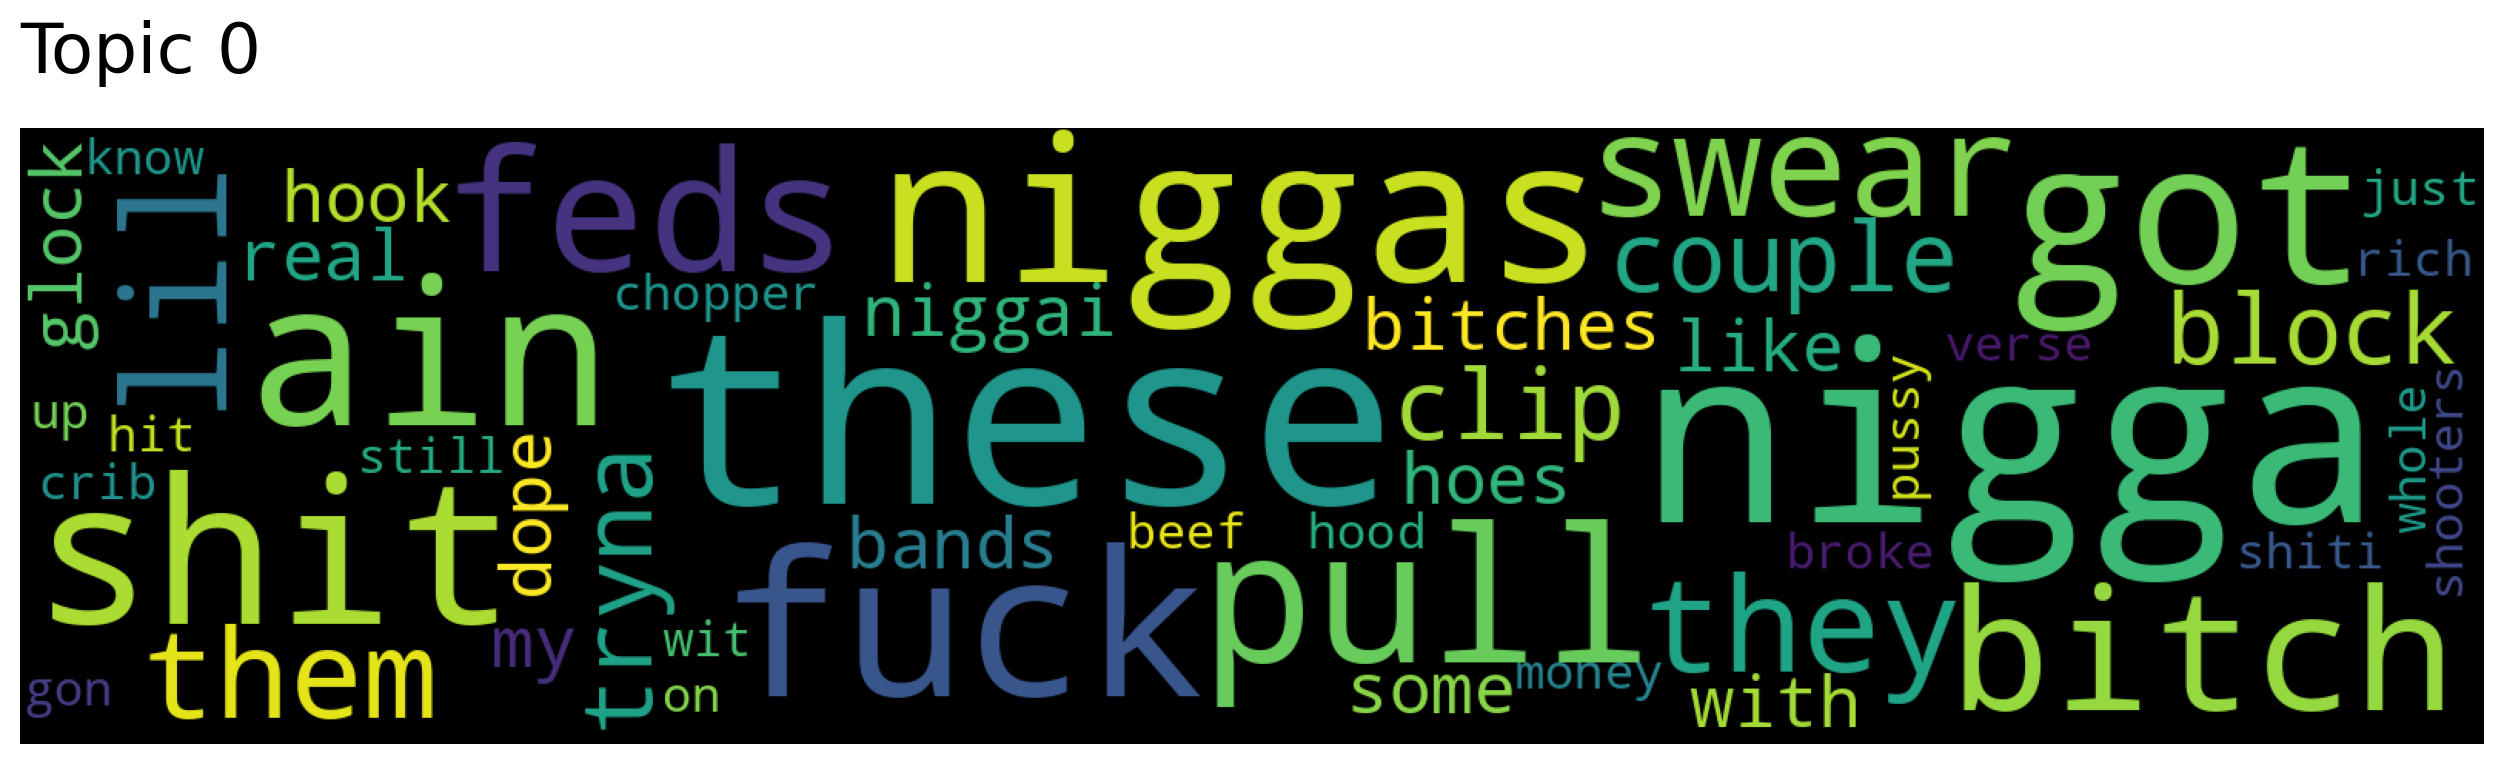

In [28]:
model.generate_topic_wordcloud(topic_nums[0])

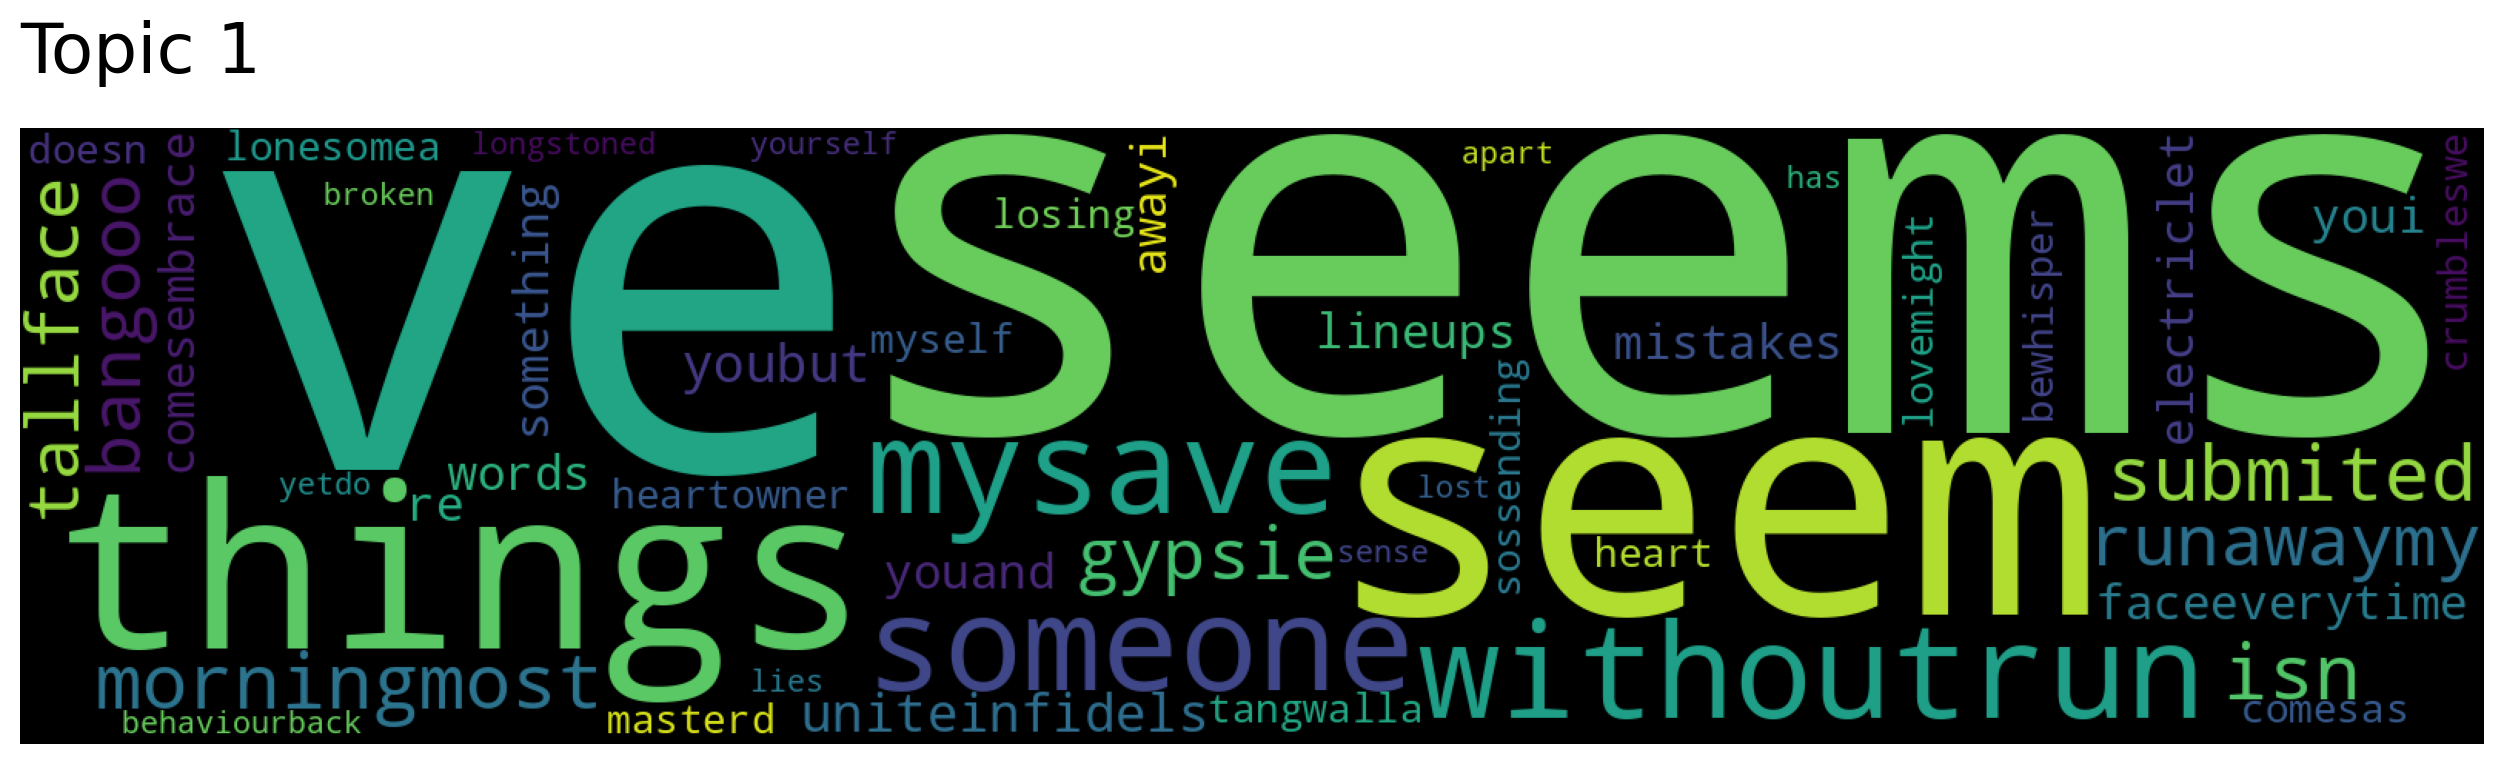

In [29]:
model.generate_topic_wordcloud(topic_nums[1])

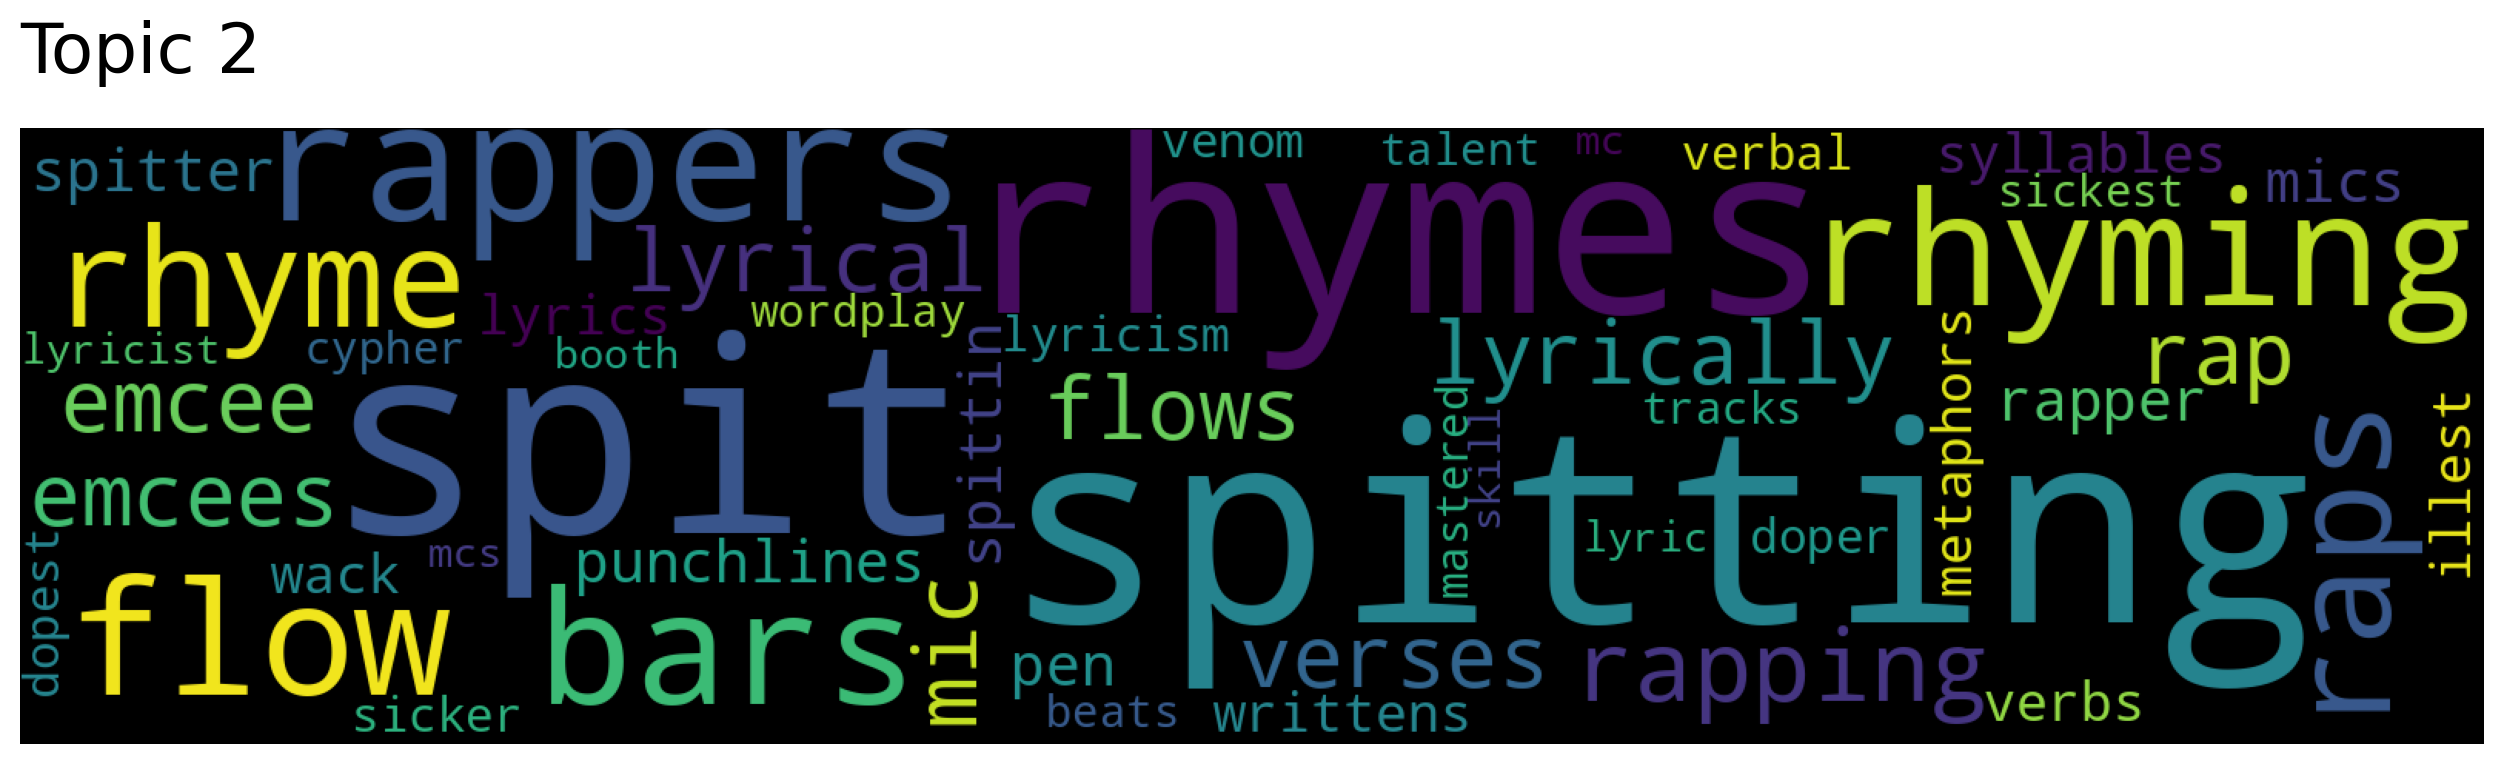

In [30]:
model.generate_topic_wordcloud(topic_nums[2])

In [31]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=0, num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 124850, Score: 0.7590472102165222
-----------
bitches ain't shit so just give them upbitches ain't shit so just give them upbitches ain't shit so just give them upbitches ain't shit so just give them upbitches ain't shit so just give them upbitches ain't shit so just give them upbitches ain't shit so just give them upbitches ain't shit so just give them upfuck fuck fuck fuck that bitchu ain't shitsuck my dicklick and spit
-----------

Document: 68285, Score: 0.7541798949241638
-----------
keep it realain't no need for frontin'if you ain't talkin money you ain't talkin bout nothinmy jewelry look disgustin'dat ain't no discusion
-----------

Document: 161619, Score: 0.7192232012748718
-----------
i got like five bitches i don't need a thotaye post it on the block i let that 30 popaye shooters with me nigga we pack like rocknigga time is money you don't own a clockaye post it at the trap i'm with the robbersaye lil o i'm fucking nigga's daughtersnigga get it jumping like it's pa

# 2000 song lyrics topic modelling

In [33]:
df_2000_en = df[(df['year'] == 2000) & (df['language'] == 'en')]
df_2000_en.head()

title   tag                   artist  year  views  \
0          Life Floats By  rock             The Jayhawks  2000     91   
12                Glisten  rock                     Isis  2000    821   
92   Guess The Politician   pop  The Legendary Pink Dots  2000     99   
108     Spring of Freedom   pop                     RPWL  2000    126   
160                  Vega   pop             Paul Van Dyk  2000    117   

    features                                             lyrics       id  \
0         {}  [Verse 1]\nAbuse me and confuse me\nBut never,...  1325199   
12        {}  Drawn in\nKneeling, scraping, praying\n\nHer l...  1325211   
92        {}  When the fireworks start where will they be? T...  1325296   
108       {}  The kingdom was far away down by the sea\nWher...  1325316   
160       {}  There's a time for us to let go\nThere's a tim...  1325369   

    language_cld3 language_ft language  
0              en          en       en  
12             en          en       en  
92             en          en       en  
108            en          en       en  
160            en          en       en

In [34]:
# retrieve groups
total_tag_views = df_2000_en.groupby(['tag'])['views'].sum()
tag_freq = df_2000_en.groupby(['tag']).size()

# create df
df_tag = pd.DataFrame({'count' : tag_freq,'total_views' :total_tag_views})
df_tag.reset_index(inplace = True, names = 'tag')

# print the barplot
fig = px.bar(df_tag, x="tag", y="count", color='total_views')
fig.show()

In [38]:
df_2000_en.sort_values(by = 'views', ascending=False).head(10)

title      tag                             artist  \
661366  Grinch Schedule Dialogue      pop                         Jim Carrey   
283655           I Almost Let Go      pop  Kurt Carr & The Kurt Carr Singers   
32678                I’m the Map      pop                  Dora the Explorer   
66775    Dora The Explorer Theme      pop                  Dora the Explorer   
431365          I Hope You Dance  country                     Lee Ann Womack   
67875                   Superman      pop                  Five for Fighting   
423264         Backpack Backpack      pop                  Dora the Explorer   
535971            Four days late      pop             Karen Peck & New River   
497947                 Supergirl     rock                            Reamonn   
185054         Holy Are You Lord      pop                     Terry MacAlmon   

        year   views                                           features  \
661366  2000  153264                                                 {}   
283655  2000  125007                                                 {}   
32678   2000  115460                                    {"Marc Weiner"}   
66775   2000  109832  {"Harrison Chad","Marc Weiner","Kathleen Herles"}   
431365  2000   80415                                                 {}   
67875   2000   77929                                                 {}   
423264  2000   70645                                     {"Sasha Toro"}   
535971  2000   68358                                                 {}   
497947  2000   53404                                                 {}   
185054  2000   42026                                                 {}   

                                                   lyrics       id  \
661366  The nerve of those Whos!\nInviting me done the...  2209308   
283655  I almost let go\nI felt like I couldn't take l...  1625031   
32678   [MAP]\nIf there's a place you got to go\nI'm t...  1359739   
66775   Dora!\nBoots!\nCome on, Dora\n\nDo-do-do-do-Do...  1395900   
431365  [Verse 1]\nI hope you never lose your sense of...  1786575   
67875   [Verse 1]\nI can't stand to fly\nI'm not that ...  1397050   
423264  [Chorus]\nBackpack, backpack\nBackpack, backpa...  1774080   
535971  The news came that Jesus\nPlease come fast\nLa...  1976820   
497947  [Verse 1]\nYou can tell by the way she walks t...  1929581   
185054  [Verse]\nHear the sound of heaven\nLike the so...  1520882   

       language_cld3 language_ft language  
661366            en          en       en  
283655            en          en       en  
32678             en          en       en  
66775             en          en       en  
431365            en          en       en  
67875             en          en       en  
423264            en          en       en  
535971            en          en       en  
497947            en          en       en  
185054            en          en       en

In [45]:
results = df_2000_en["lyrics"].apply(clean_text)

docs = results.to_list()
docs[:2]

[" abuse me and confuse mebut never never never use meah you leave me so tiredso utterly uninspired thunder bay was a drag babythunder bay was a drag baby upon the gravel and the dustif i don't move i will rustyou're a faint recurring melodyi can't seem to recall in my mind in my souli never really loved youin my mind in my souli never really loved you ah the sun shines off the power linesand the trees they wave me onthere's a black cloud of happinessi can't finish what i've begun we hit duluth on a jag babywe hit duluth on a jag baby i grab my coat my hat and my paperbackfrom the corner of my eyes i see you smile in my mind in my souli never really loved youin my mind in my souli never really loved you i hear what they're sayingthere's no use in prayingso i'll just slip away  in my mind in my souli never really loved youin my mind in my souli never really loved you do do dodo do dodo do do do do do dodo do dodo do dodo do do do do do dodo do dodo do dodo do do do do do do ",
 "drawn i

In [50]:
model_2000 = Top2Vec(docs, speed = 'fast-learn', workers = multiprocessing.cpu_count())

2023-03-07 23:47:54,597 - top2vec - INFO - Pre-processing documents for training
2023-03-07 23:47:59,253 - top2vec - INFO - Creating joint document/word embedding
2023-03-07 23:49:31,142 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-07 23:49:42,702 - top2vec - INFO - Finding dense areas of documents
2023-03-07 23:49:43,302 - top2vec - INFO - Finding topics


In [51]:
today = datetime.now().strftime("%d%m%Y")

path = "models/" + "top2vec_2000_" + today

model_2000.save(path)
model_2000 = Top2Vec.load(path)

In [52]:
model_2000.get_num_topics()

4

In [54]:
topic_words, word_scores, topic_nums = model_2000.get_topics(4)
topic_words[0]

array(['jamie', 'thomas', 'ly', 'loo', 'in', 'of', 'to', 'the', 'you',
       'that', 'and', 'my', 'junt', 'be', 'for', 'as', 'it', 'just',
       'time', 'is', 've', 'll', 'can', 'blah', 'emerge', 'not', 'our',
       'never', 'eyes', 'me', 'on', 'have', 'this', 'woof', 'could',
       'they', 'through', 'but', 'was', 'your', 'all', 'there', 'know',
       'are', 'were', 'has', 'with', 'take', 'see', 'death'], dtype='<U9')

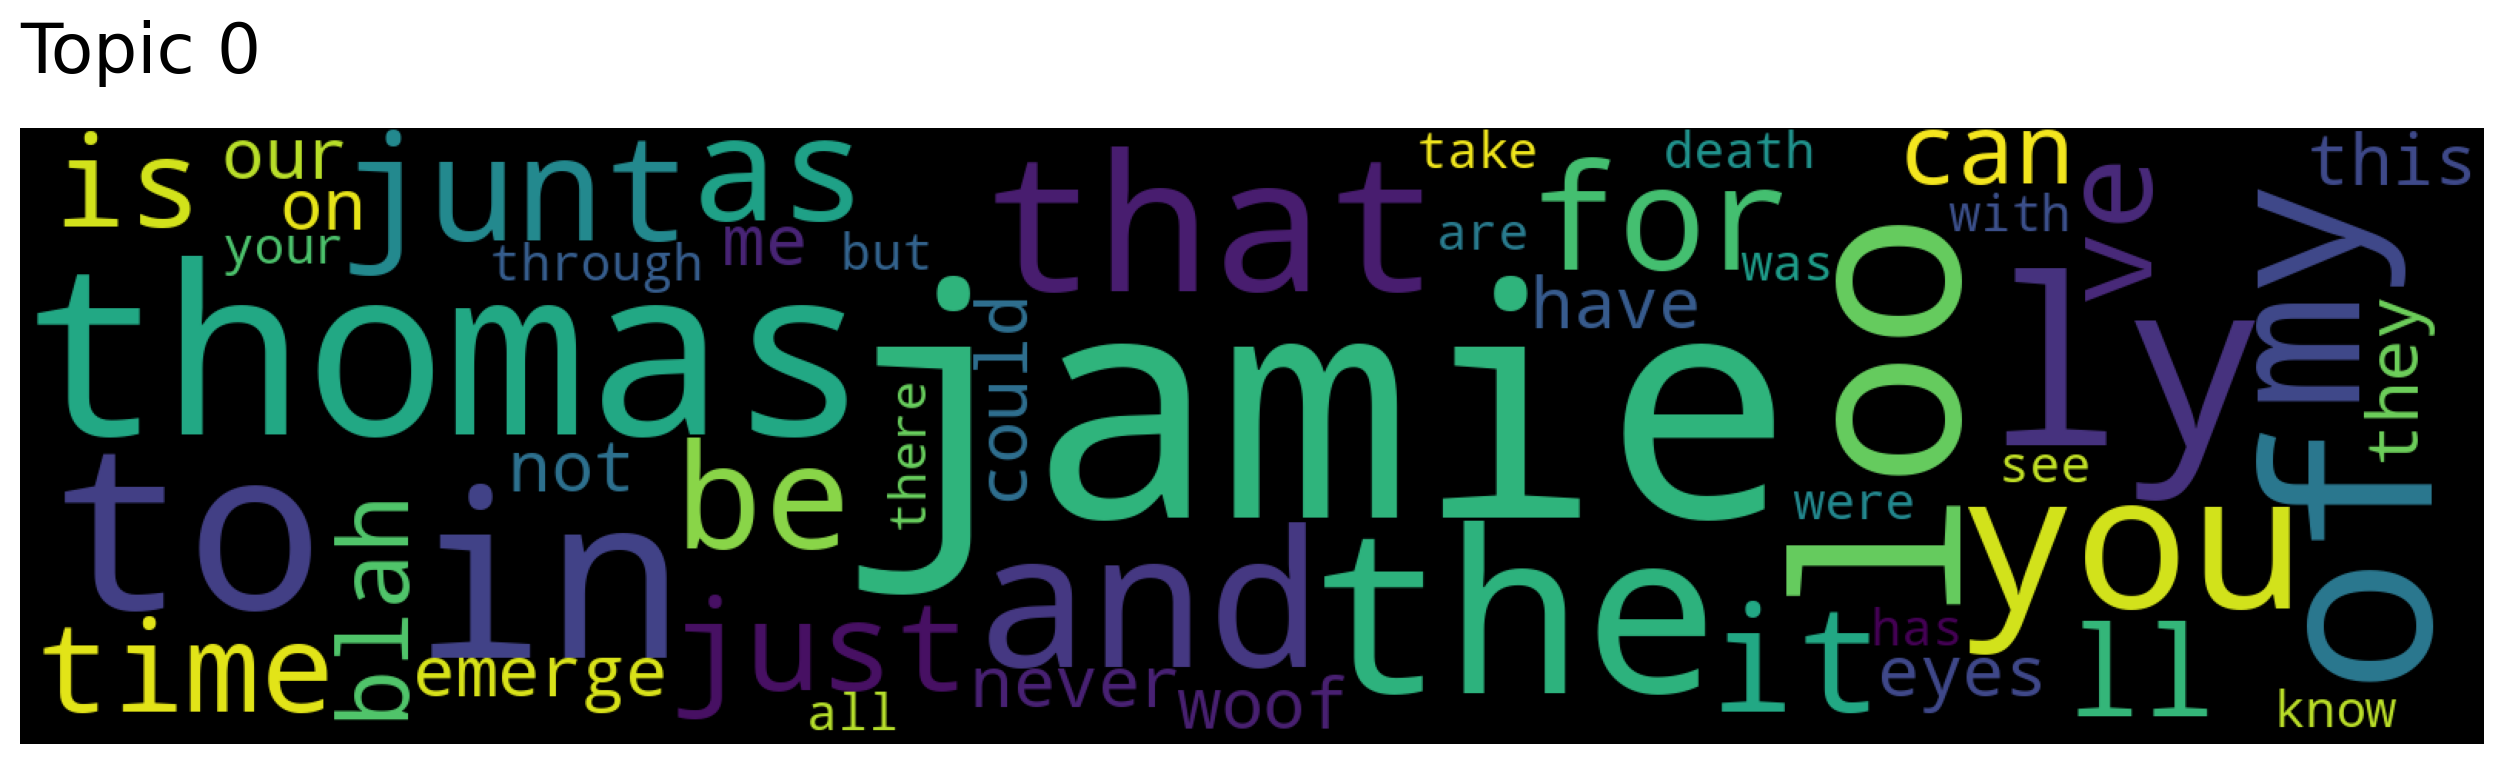

In [55]:
model_2000.generate_topic_wordcloud(topic_nums[0])

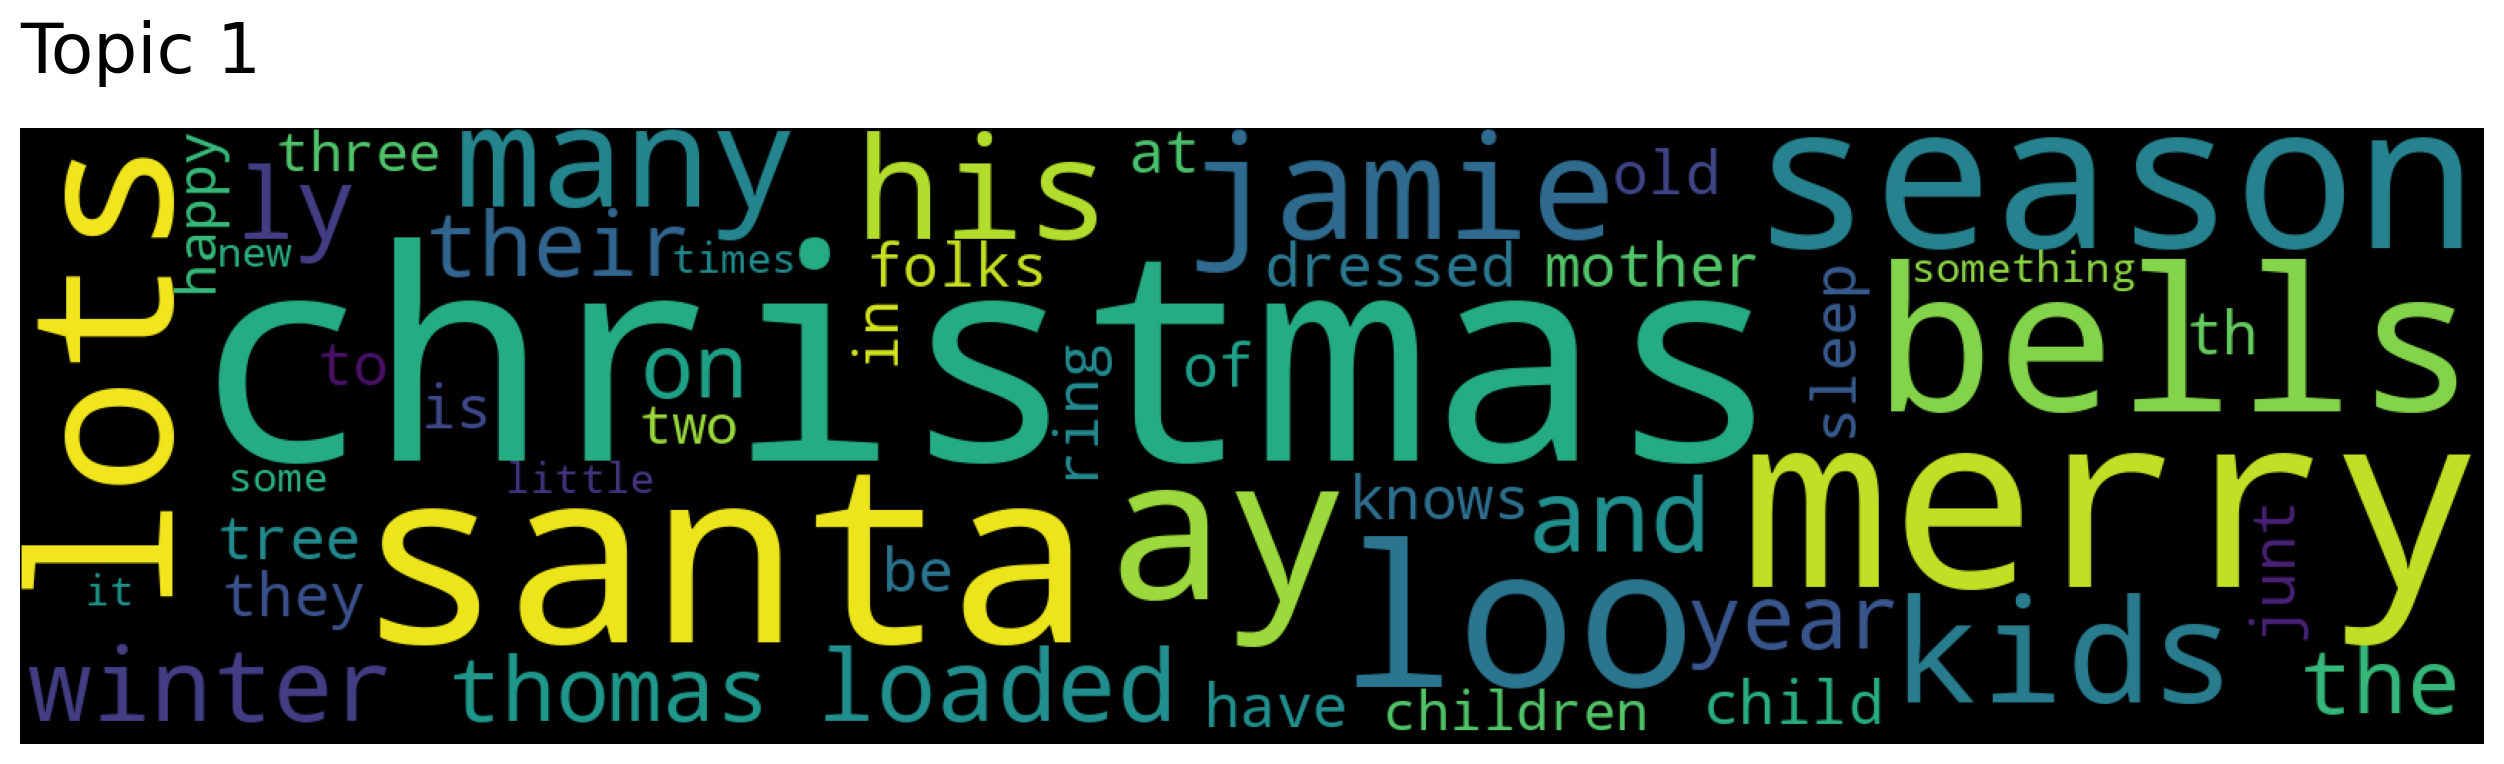

In [56]:
model_2000.generate_topic_wordcloud(topic_nums[1])

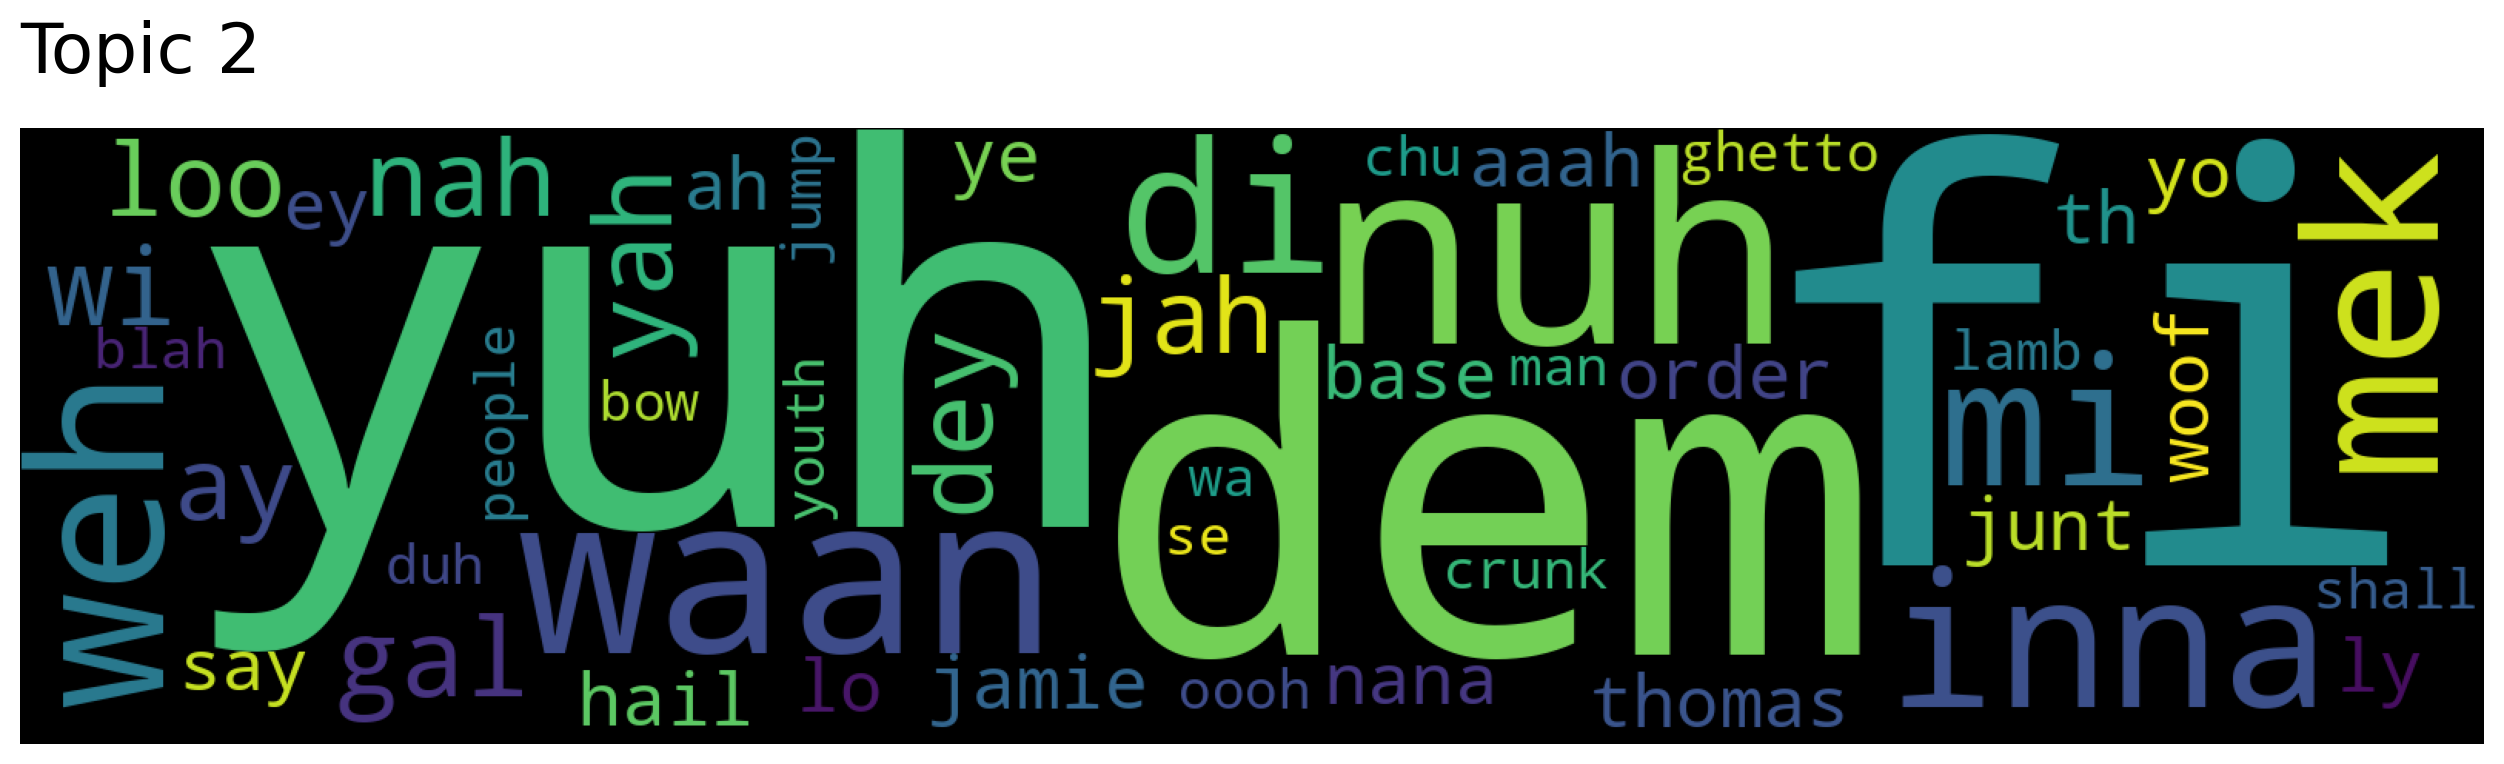

In [57]:
model_2000.generate_topic_wordcloud(topic_nums[2])

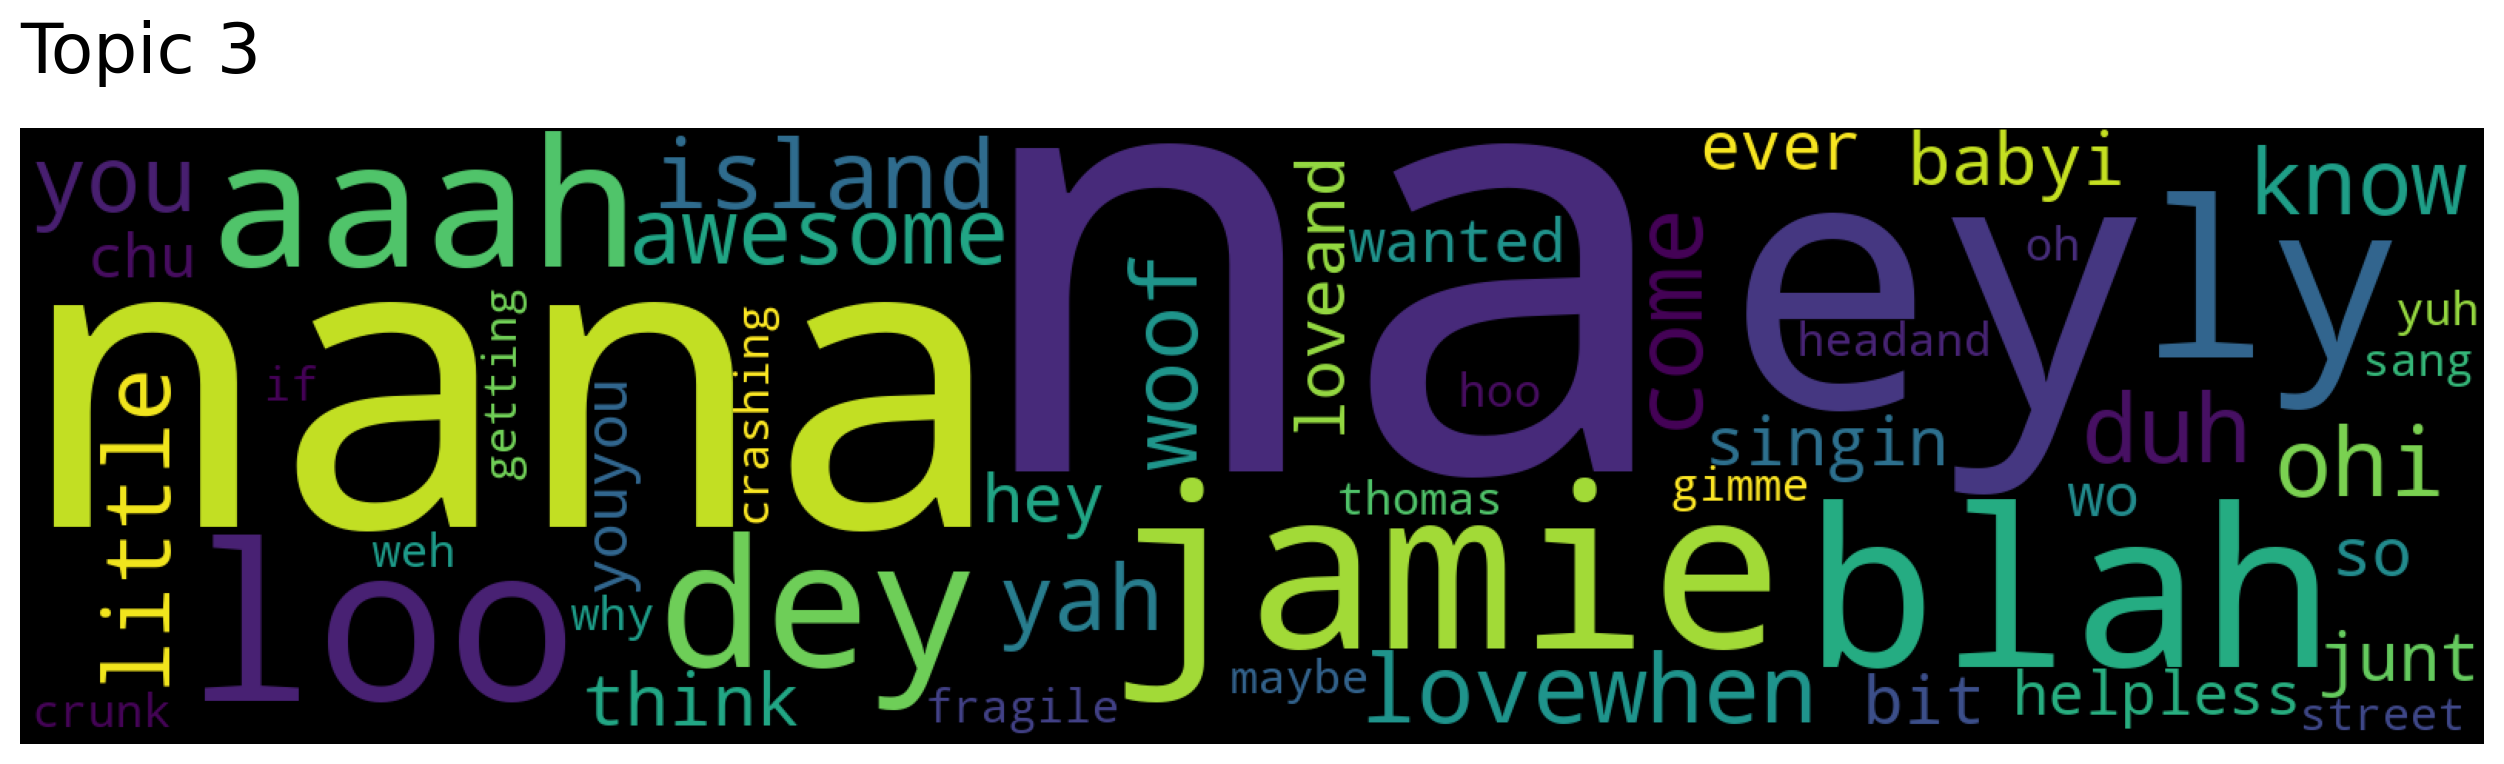

In [58]:
model_2000.generate_topic_wordcloud(topic_nums[3])

## References